In [ ]:
from google.colab import files
uploaded = files.upload()  # selecciona movies_FINAL.csv


Saving movies_FINAL.csv to movies_FINAL.csv


# Cargar el CSV


In [ ]:
import pandas as pd, csv, re

def load_csv_robust(path):
    encodings = ["utf-8", "utf-8-sig", "latin-1"]
    seps = [",", ";", "|", "\t"]
    last_err = None

    for enc in encodings:
        # intento detectar el separador con Sniffer
        try:
            with open(path, "r", encoding=enc, errors="replace") as f:
                sample = f.read(65536)
            try:
                guess = csv.Sniffer().sniff(sample, delimiters=";,|\t,").delimiter
                seps = [guess] + [s for s in seps if s != guess]
            except Exception:
                pass
        except Exception as e:
            last_err = e
            continue

        # pruebo leer con varios separadores
        for sep in seps:
            try:
                df = pd.read_csv(
                    path,
                    sep=sep,
                    engine="python",
                    encoding=enc,
                    quotechar='"',
                    escapechar="\\",
                    on_bad_lines="warn",  # si alguna fila viene dañada, la avisa pero no rompe
                )
                print(f"✓ Leído con encoding={enc}, sep={repr(sep)} -> shape {df.shape}")
                return df, enc, sep
            except Exception as e:
                last_err = e
                # sigue probando
    raise last_err

df, enc, sep = load_csv_robust("movies_FINAL.csv")
df.head(3)


✓ Leído con encoding=utf-8, sep=';' -> shape (4364, 27)


,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,genres,actor_1_name,movie_title,...,language,country,content_rating,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,budget_filled,gross_filled
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,...,English,USA,PG-13,2009.0,936.0,7.9,1.78,33000,237000000.0,760505847.0
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,...,English,USA,PG-13,2007.0,5000.0,7.1,2.35,0,300000000.0,309404152.0
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,...,English,UK,PG-13,2015.0,393.0,6.8,2.35,85000,245000000.0,200074175.0


In [ ]:
df.to_csv("movies_FINAL_CLEAN.csv", index=False, encoding="utf-8")


# Seleccionar la columna de texto y limpiar plot_keywords

In [ ]:
# Preferimos plot_keywords; si no existe, usamos keywords
text_col = None
for c in ["plot_keywords", "keywords"]:
    if c in df.columns:
        text_col = c
        break

if text_col is None:
    raise ValueError("No se encontró la columna 'plot_keywords' ni 'keywords'.")

import re
def limpiar_kw(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.lower().strip()
    s = re.sub(r"[|;/]", " ", s)     # separadores -> espacio
    s = s.replace("-", "_")          # conservar multi-palabras
    s = re.sub(r"[^a-z0-9_\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["keywords_clean"] = df[text_col].fillna("").astype(str).apply(limpiar_kw)
df[[text_col, "keywords_clean"]].head(5)


,plot_keywords,keywords_clean
0,avatar|future|marine|native|paraplegic,avatar future marine native paraplegic
1,goddess|marriage ceremony|marriage proposal|pi...,goddess marriage ceremony marriage proposal pi...
2,bomb|espionage|sequel|spy|terrorist,bomb espionage sequel spy terrorist
3,deception|imprisonment|lawlessness|police offi...,deception imprisonment lawlessness police offi...
4,NaN,


# TF-IDF (matriz no negativa para NMF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),            # unigramas y bigramas
    min_df=5,                     # relaja a 2 si tu vocabulario queda chico
    max_df=0.6,
    token_pattern=r"(?u)\b\w[\w_]+\b"  # conserva tokens con guion_bajo
)
X = vectorizer.fit_transform(df["keywords_clean"])

# Si quedó muy pequeño, relajamos filtros
if X.shape[1] < 20:
    vectorizer = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=2,
        max_df=0.9,
        token_pattern=r"(?u)\b\w[\w_]+\b"
    )
    X = vectorizer.fit_transform(df["keywords_clean"])

features = vectorizer.get_feature_names_out()
features
print("TF-IDF shape:", X.shape)


TF-IDF shape: (4364, 1771)


# En la matriz TF-IDF

In [ ]:
import pandas as pd

# Convertir a DataFrame con nombres de features
tfidf_df = pd.DataFrame(X.toarray(), columns=features)

# Mostrar solo las primeras 5 filas y 10 columnas
tfidf_df.iloc[:5, :10]


,17th,17th century,18th,18th century,1920s,1930s,1940s,1950s,1960s,1970s
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Cada columna corresponde a un término del vocabulario
construido a partir de las plot_keywords. Eso incluye palabras sueltas (avatar, future, love) y también combinaciones de dos palabras (science_fiction, martial_arts), porque usaste ngram_range=(1,2).

- Cada fila representa una película.

- Cada valor numérico es el peso TF-IDF que indica cuánto caracteriza esa palabra (columna) a esa película (fila).





In [ ]:
# Ejemplo: mostrar la fila 0 con los términos que tienen valor > 0
row0 = tfidf_df.iloc[0]
row0_nonzero = row0[row0 > 0]
row0_nonzero


,0
future,0.472915
marine,0.607543
native,0.638155


In [ ]:
density = X.nnz / (X.shape[0] * X.shape[1])
print(f"Densidad de la matriz: {density:.4f}")


Densidad de la matriz: 0.0037


Esto indica qué porcentaje de celdas tienen valores distintos de cero (suele ser muy bajo, 1–5%).

# Elegir k (temas) con curva del “codo” y entrenar NMF

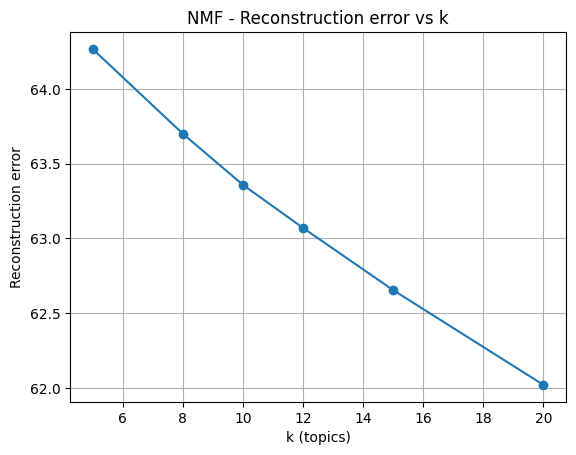

k elegido: 12


In [ ]:
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt

K_LIST = [5, 8, 10, 12, 15, 20]
errors, models = [], []

for k in K_LIST:
    nmf = NMF(n_components=k, init="nndsvd", solver="cd",
              beta_loss="frobenius", max_iter=600, random_state=42)
    W = nmf.fit_transform(X)
    H = nmf.components_
    errors.append(nmf.reconstruction_err_)
    models.append((nmf, W, H))

plt.plot(K_LIST, errors, marker="o")
plt.title("NMF - Reconstruction error vs k")
plt.xlabel("k (topics)")
plt.ylabel("Reconstruction error")
plt.grid(True)
plt.show()

# Heurística simple para elegir k
drops = np.diff(errors)
chosen_k = K_LIST[np.argmin(np.abs(drops / np.array(errors[:-1])))+1] if len(drops) else K_LIST[0]
nmf, W, H = models[K_LIST.index(chosen_k)]
print("k elegido:", chosen_k)


# Interpretar temas (palabras top por tema)

In [ ]:
def top_words(H, feats, topn=12):
    for i, comp in enumerate(H):
        idx = np.argsort(comp)[::-1][:topn]
        print(f"Tema {i}: " + ", ".join(feats[idx]))

top_words(H, features, topn=12)


Tema 0: new, new york, york, city, york city, manhattan new, manhattan, city new, york new, city police, fashion, love new
Tema 1: nudity, male, frontal, frontal nudity, nudity male, male nudity, male frontal, full, full frontal, female nudity, rear, pubic
Tema 2: school, high, high school, teacher, student, teenager, basketball, school high, football, coach, school student, prom
Tema 3: title, in, in title, word, word title, name in, name, the, three word, three, in the, one
Tema 4: on, based, based on, true, story, true story, on true, novel, on novel, book, the, comic
Tema 5: love, death, of, marriage, relationship, sister, love marriage, train, werewolf, father, war, son
Tema 6: office, box, box office, office flop, flop, office hit, critically bashed, bashed, hit, critically, flop critically, dog
Tema 7: police, detective, police officer, officer, murder, police police, drugs, murder police, cop, police detective, partner, prison
Tema 8: to, reference, reference to, the, to the, o

# Top palabras por tema (gráfico de barras)


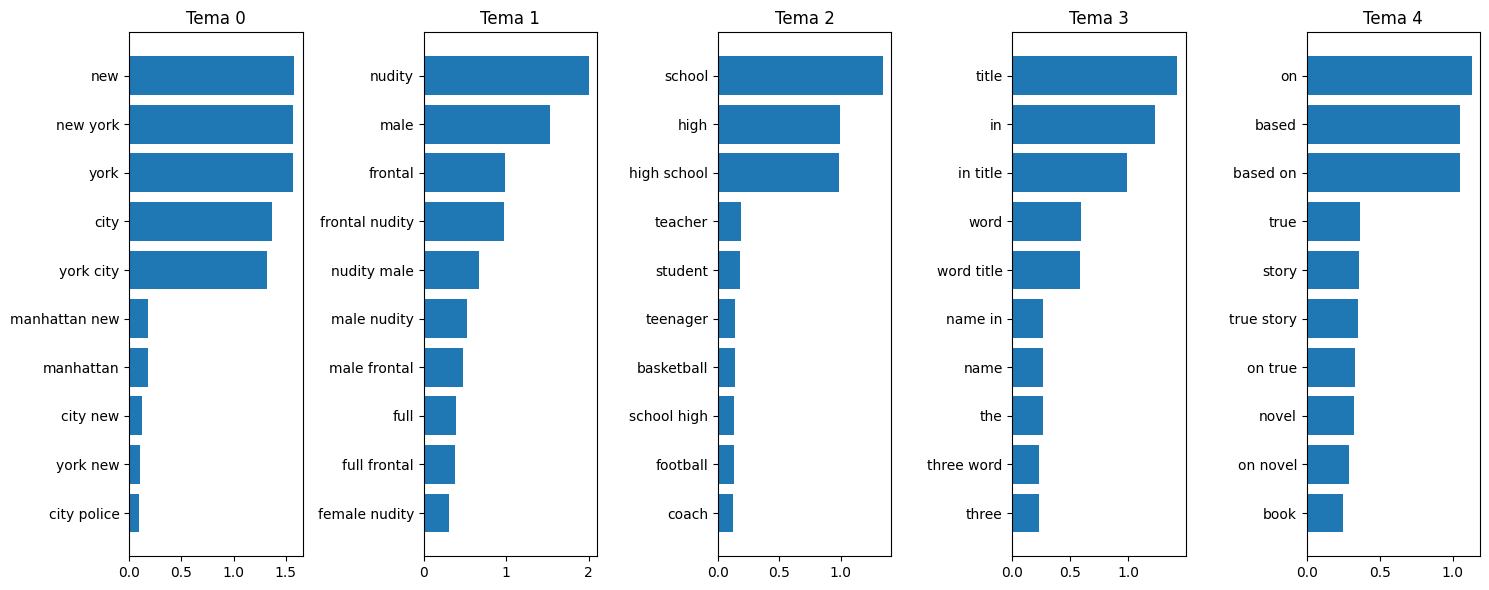

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_words(H, features, n_top_words=10, n_topics=5):
    fig, axes = plt.subplots(1, n_topics, figsize=(15, 6), sharex=False)
    for i, ax in enumerate(axes):
        idx = np.argsort(H[i])[::-1][:n_top_words]
        ax.barh([features[j] for j in idx][::-1], H[i, idx][::-1])
        ax.set_title(f"Tema {i}")
    plt.tight_layout()
    plt.show()

plot_top_words(H, features, n_top_words=10, n_topics=min(5, H.shape[0]))


# Mezcla de temas por película y tema principal

In [ ]:
topics = pd.DataFrame(W, columns=[f"topic_{i}" for i in range(W.shape[1])])

# Normalizamos por fila (suma=1) para interpretar como mezcla
row_sum = topics.sum(axis=1).replace(0, np.nan)
topics = topics.div(row_sum, axis=0).fillna(0.0)

# Añadimos un identificador legible (título)
title_col = "movie_title" if "movie_title" in df.columns else ("title" if "title" in df.columns else df.columns[0])
topics[title_col] = df[title_col]

# Tema predominante
topics["top_topic"] = topics.filter(like="topic_").idxmax(axis=1)
topics.head(5)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,movie_title,top_topic
0,0.000000,0.000000,0.000000,0.0,0.011577,0.119526,0.063826,0.110613,0.046979,0.053746,0.382884,0.210849,Avatar,topic_10
1,0.000000,0.000000,0.000000,0.0,0.000000,0.940945,0.000000,0.000000,0.000000,0.000000,0.000000,0.059055,Pirates of the Caribbean: At World's End,topic_5
2,0.062369,0.004755,0.017892,0.0,0.023781,0.000000,0.100049,0.147789,0.089231,0.000000,0.530489,0.023644,Spectre,topic_10
3,0.000035,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.999965,0.000000,0.000000,0.000000,0.000000,The Dark Knight Rises,topic_7
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Star Wars: Episode VII - The Force Awakens ...,topic_0


# Relacionar con éxito: gross / imdb_score

In [ ]:
# Adjuntar métricas si existen
if "gross" in df.columns:
    topics["gross"] = pd.to_numeric(df["gross"], errors="coerce")
if "imdb_score" in df.columns:
    topics["imdb_score"] = pd.to_numeric(df["imdb_score"], errors="coerce")

agg = {"movies": ("top_topic","size")}
if "gross" in topics.columns: agg["mean_gross"] = ("gross","mean")
if "imdb_score" in topics.columns: agg["mean_imdb"] = ("imdb_score","mean")

summary = topics.groupby("top_topic").agg(**agg).reset_index()

# palabras top para hacer legible el resumen
topic_words = []
for i, comp in enumerate(H):
    idx = np.argsort(comp)[::-1][:8]
    topic_words.append(", ".join(features[idx]))
mapping = {f"topic_{i}": w for i, w in enumerate(topic_words)}
summary["topic_words"] = summary["top_topic"].map(mapping)

summary.sort_values("movies", ascending=False)


,top_topic,movies,mean_imdb,topic_words
2,topic_10,892,6.448318,"fbi, murder, agent, killer, serial, serial kil..."
7,topic_5,852,6.697066,"love, death, of, marriage, relationship, siste..."
9,topic_7,414,6.662560,"police, detective, police officer, officer, mu..."
3,topic_11,401,6.351870,"female, sex, protagonist, female protagonist, ..."
11,topic_9,369,6.511111,"friend, best friend, best, friendship, wedding..."
5,topic_3,277,6.243682,"title, in, in title, word, word title, name in..."
6,topic_4,268,6.557090,"on, based, based on, true, story, true story, ..."
4,topic_2,257,6.435019,"school, high, high school, teacher, student, t..."
0,topic_0,193,6.403109,"new, new york, york, city, york city, manhatta..."
10,topic_8,177,6.463277,"to, reference, reference to, the, to the, of, ..."


“El modelo NMF nos permitió descubrir temas similares a los géneros oficiales, pero también mezclas interesantes: por ejemplo, un tema donde aparecen keywords de guerra y tecnología, que no corresponde a un único género, sino a un híbrido de acción y ciencia ficción.”

# Temas sobre-representados en el top 25%

In [ ]:
def top_quartile(s):
    s = pd.to_numeric(s, errors="coerce").dropna()
    return np.quantile(s, 0.75) if not s.empty else np.nan

if "gross" in topics.columns:
    gq = top_quartile(topics["gross"])
    if not np.isnan(gq):
        t_gross = (topics.assign(success = topics["gross"] >= gq)
                   .groupby(["top_topic","success"]).size().unstack(fill_value=0))
        print("\nTópicos vs éxito (top 25% gross):")
        display(t_gross)

if "imdb_score" in topics.columns:
    iq = top_quartile(topics["imdb_score"])
    if not np.isnan(iq):
        t_imdb = (topics.assign(success = topics["imdb_score"] >= iq)
                  .groupby(["top_topic","success"]).size().unstack(fill_value=0))
        print("\nTópicos vs éxito (top 25% IMDB):")
        display(t_imdb)



Tópicos vs éxito (top 25% IMDB):


success,False,True
top_topic,,
topic_0,142,51
topic_1,93,35
topic_10,666,226
topic_11,302,99
topic_2,189,68
topic_3,216,61
topic_4,177,91
topic_5,565,287
topic_6,107,29


In [ ]:
# Diccionario de temas
topics_dict = pd.DataFrame({
    "topic": list(range(H.shape[0])),
    "top_words": [", ".join(features[np.argsort(H[i])[::-1][:12]]) for i in range(H.shape[0])]
})
topics_dict.to_csv("NMF_topics_dictionary.csv", index=False)

# Pesos por película
topics.to_csv("movies_with_topics_FINAL.csv", index=False)

print("Guardado:\n - NMF_topics_dictionary.csv\n - movies_with_topics_FINAL.csv")


Guardado:
 - NMF_topics_dictionary.csv
 - movies_with_topics_FINAL.csv


# Distribución de películas por tema (gráfico de barras)

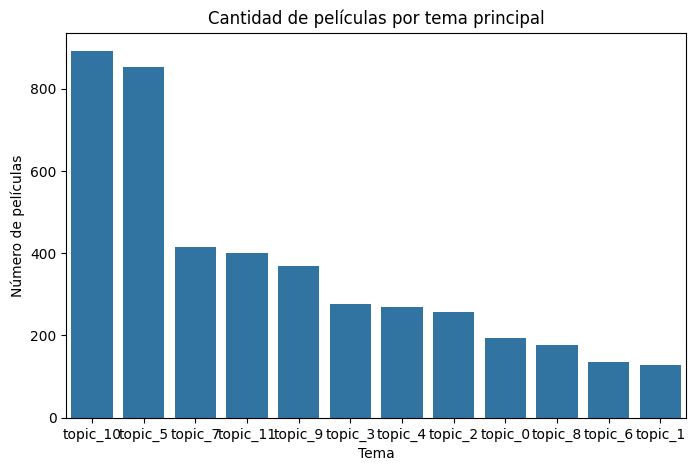

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(data=topics, x="top_topic", order=topics["top_topic"].value_counts().index)
plt.title("Cantidad de películas por tema principal")
plt.xlabel("Tema")
plt.ylabel("Número de películas")
plt.show()


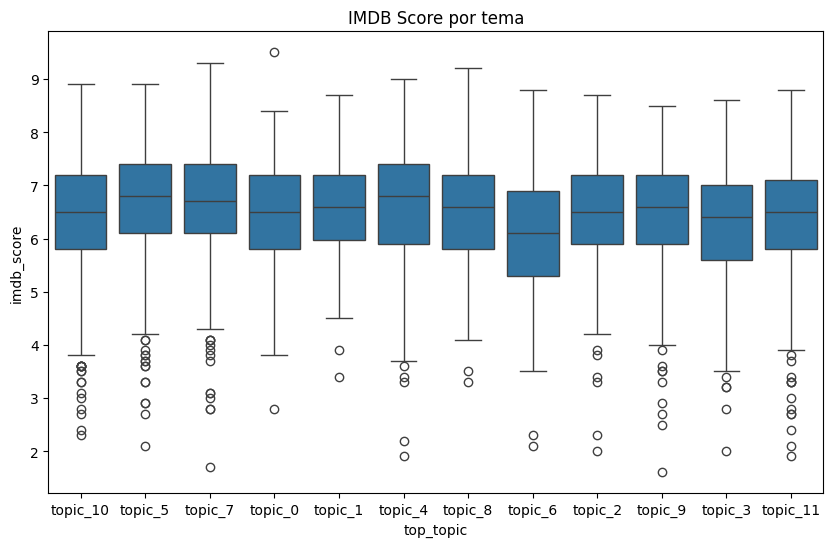

In [ ]:
if "gross" in topics.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=topics, x="top_topic", y="gross")
    plt.title("Recaudación (gross) por tema")
    plt.show()

if "imdb_score" in topics.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=topics, x="top_topic", y="imdb_score")
    plt.title("IMDB Score por tema")
    plt.show()
